In [51]:
import pandas as pd
import numpy as np
path = 'dataset/labelled_tweets.csv'
    
tweet = pd.read_csv(path, usecols=['text', 'polarity'])
# Remove rows will nan values
tweet = tweet.dropna()
tweet = tweet.reindex(np.random.permutation(tweet.index))
# preprocessing bit
# replace user handles (@Jumia) to be empty
pattern = "(@[A-Za-z0-9]+)|(http|https|ftp)://[a-zA-Z0-9./]+|#(\w+)"
tweet['text'] = tweet.text.str.replace(pattern, '')
tweet.head()

,polarity,text
567,neutral,What was the result from quality assessment ?
1218,negative,You keep apologizing and looking into the matt...
617,neutral,Maybe
1307,neutral,"Am Philip,I bought a phone,type infinix hot no..."
332,neutral,Hi. I'd like to return a defective product. W...


In [52]:
# examine class distribution
print(tweet.polarity.value_counts())

neutral     959
negative    748
positive    100
Name: polarity, dtype: int64


In [53]:
# Summary of data
print(tweet.describe())

       polarity       text
count      1807       1807
unique        3       1763
top     neutral  Thank you
freq        959         13


### Dataset Visualization

In [54]:
# convert label to a numerical count by creating a new column
tweet['polarity_num'] = tweet.polarity.map({'negative':0,'positive':1,'neutral':2})

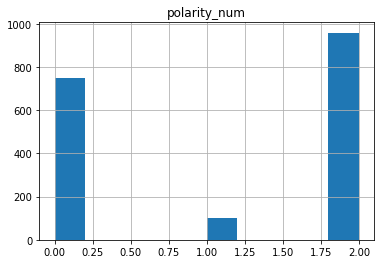

In [55]:
import matplotlib.pyplot as plt
tweet.hist()
plt.show()

In [56]:
# Define X matrix as features and y as vectors
X = tweet.text
y = tweet.polarity_num
print(X.shape)
print(y.shape)

(1807,)
(1807,)


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1355,)
(452,)
(1355,)
(452,)


In [58]:
# Import libraries
import re
import numpy as np

from sklearn import model_selection

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [59]:
vect = TfidfVectorizer()

x_train = vect.fit_transform(X_train)

### Test Harness
* Use 10-fold cross validation to determine the best classifier.
* Metric accuracy is used to evaluate the models. (A ratio of number of correctly predicted instances divided by total number of the instances in dataset-tweet)

In [64]:
seed = 4
# Evaluation metric
scoring = 'accuracy'

# Models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('SVM', SVC()))
models.append(('SGDC', SGDClassifier()))
# Evaluate model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(message)

C:\Users\brian\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


LR: 0.743943 (0.030764)
KNN: 0.527712 (0.046998)
CART: 0.687805 (0.030010)
SVM: 0.522544 (0.042097)
SGDC: 0.759455 (0.041709)


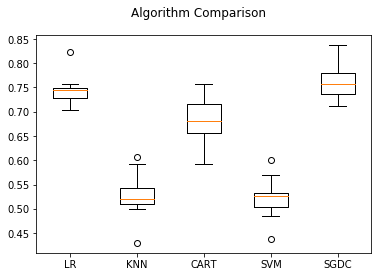

In [62]:
# TODO: Visual comparison of algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### SGDClassifier

In [88]:
clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(use_idf=True)), ('clf', SGDClassifier(loss='hinge',penalty='l2', n_iter=5,alpha=0.001,random_state=42))])
clf_svm = clf_svm.fit(X_train,y_train)
y_pred_svm = clf_svm.predict(X_test)
print(metrics.classification_report(y_test, y_pred_svm))
print("SGDClassifier Accuracy: ", metrics.accuracy_score(y_test, y_pred_svm))

             precision    recall  f1-score   support

          0       0.71      0.79      0.75       170
          1       0.69      0.29      0.41        31
          2       0.79      0.78      0.78       251

avg / total       0.75      0.75      0.74       452

SGDClassifier Accuracy:  0.75


C:\Users\brian\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


### Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression
clf_reg = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])
clf_reg = clf_reg.fit(X_train,y_train)
y_pred_reg = clf_reg.predict(X_test)
print(metrics.classification_report(y_test, y_pred_reg))
print("Logistic Regression Accuracy: ", metrics.accuracy_score(y_test, y_pred_reg))

             precision    recall  f1-score   support

          0       0.72      0.77      0.74       170
          1       0.67      0.06      0.12        31
          2       0.76      0.81      0.78       251

avg / total       0.74      0.74      0.72       452

Logistic Regression Accuracy:  0.743362831858


### Grid Search
Obtain the best parameters to pass to the model, for best classification accuracy

In [69]:
from sklearn.model_selection import GridSearchCV 
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3),}

gs_clf = GridSearchCV(clf_svm, parameters, n_jobs=-1, cv=10)
gs_clf = gs_clf.fit(X_train, y_train)

In [70]:
gs_clf.best_score_

0.76236162361623616

In [71]:
gs_clf.best_params_

{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

### Confusion Matrix


This snippet of code was extracted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

Confusion matrix, without normalization
[[135   0  35]
 [  4   9  18]
 [ 52   4 195]]
Normalized confusion matrix
[[ 0.79  0.    0.21]
 [ 0.13  0.29  0.58]
 [ 0.21  0.02  0.78]]


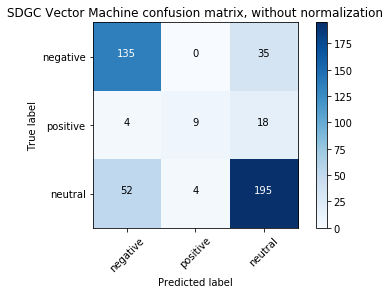

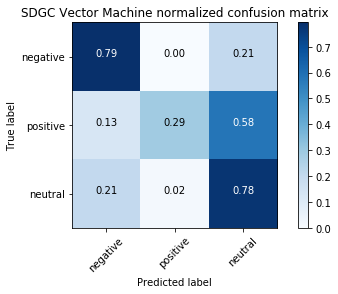

In [89]:
"""
This snippet of code was extracted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""

print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ['negative','positive','neutral']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix for all predicted y

predicted_y = [y_pred_svm]

titles = ['SDGC Vector Machine']

for index, y_prediction in enumerate(predicted_y):
    cnf_matrix = confusion_matrix(y_test, y_prediction)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title=titles[index] + ' confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=titles[index] + ' normalized confusion matrix')

    plt.show()

In [90]:
clf_svm.predict(['still'])

array([0], dtype=int64)

# Topic Modelling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_index))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(X)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 5
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

In [ ]:
nmf.components_.shape

### NMF and LDA Summarized Topics

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(X)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 2

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

no_top_words = 4
no_top_documents = 4
display_topics(nmf_H, nmf_W, tfidf_feature_names, X, no_top_words, no_top_documents)
display_topics(lda_H, lda_W, tf_feature_names, X, no_top_words, no_top_documents)

In [ ]:
titles[0]

In [ ]:
for i, title in enumerate(titles):
    print(i)